# Figure 1

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import gmean
import tensorly as tl
from tensorly.decomposition import parafac2
from tensorly.parafac2_tensor import parafac2_to_slice, apply_parafac2_projections
from tensorly.metrics.regression import variance as tl_var
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.svm import SVC
from tfac.figures.figureCommon import subplotLabel, getSetup
from tfac.MRSA_dataHelpers import produce_outcome_bools, get_patient_info, form_MRSA_tensor, form_paired_tensor, importClinicalMRSA, clinicalCyto, importExpressionData, find_regularization, find_CV_proba, find_SVC_proba
from tfac.tensor import R2Xparafac2, MRSA_decomposition

tl.set_backend("numpy")



In [4]:
_, statusID = get_patient_info()
outcomes = produce_outcome_bools(statusID)
components = 38
tensors = []
tensor_slices, _, _ = form_MRSA_tensor(1, 1)
parafac2tensors = pickle.load( open( "cyto_exp.p", "rb" ) )
AllR2X = []
for comp in range(components):
    parafac2tensor = parafac2tensors[comp]
    R2X = np.round(R2Xparafac2(tensor_slices, parafac2tensor), 6)
    AllR2X.append(R2X)
pickle.dump( AllR2X, open( "R2X.p", "wb" ) )

(0.0, 1.0)

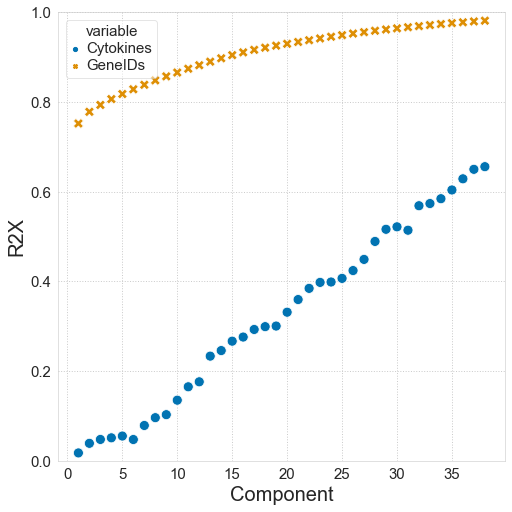

In [7]:
AllR2X = pickle.load( open( "R2X.p", "rb" ) )
components = 38
df = pd.DataFrame(AllR2X)

comps = []
for i in range(1, components + 1):
    comps.append(i)
df['Component'] = comps

df.columns = ['Cytokines', 'GeneIDs', 'Component']
test = pd.melt(df, id_vars=['Component'])
ax, f = getSetup((7, 7), (1, 1))
b = sns.scatterplot(data=test, x='Component', y='value', hue='variable', style='variable', ax=ax[0], s=100)
b.set_xlabel("Component", fontsize=20)
b.set_ylabel("R2X", fontsize=20)
b.tick_params(labelsize=15)
plt.legend(prop={'size': 15})
ax[0].set_ylim(0, 1)

# Figure 3

In [5]:
_, statusID = get_patient_info()
outcomes = produce_outcome_bools(statusID)
components = 38
patient_matrices = pickle.load( open( "cyto_exp.p", "rb" ) )
patient_matrices2 = pickle.load( open( "cyto_exp_2.p", "rb" ) )
patient_matrices3 = pickle.load( open( "cyto_exp_3.p", "rb" ) )
all_mats = [patient_matrices, patient_matrices2, patient_matrices3]
values_comps = []
for components in range(1, components + 1):
    for patient_matrices in all_mats:
        patient_matrix = patient_matrices[components - 1][1][2]
        reg = find_regularization(patient_matrix, outcomes)
        proba = find_CV_proba(patient_matrix, outcomes, random_state=None, C=reg)        
        auc = roc_auc_score(outcomes, proba)
        values_comps.append([components, auc])
df_comp = pd.DataFrame(values_comps)
df_comp.columns = ['Components', 'AUC']
pickle.dump( df_comp, open( "LogReg.p", "wb" ) )

(0.0, 1.0)

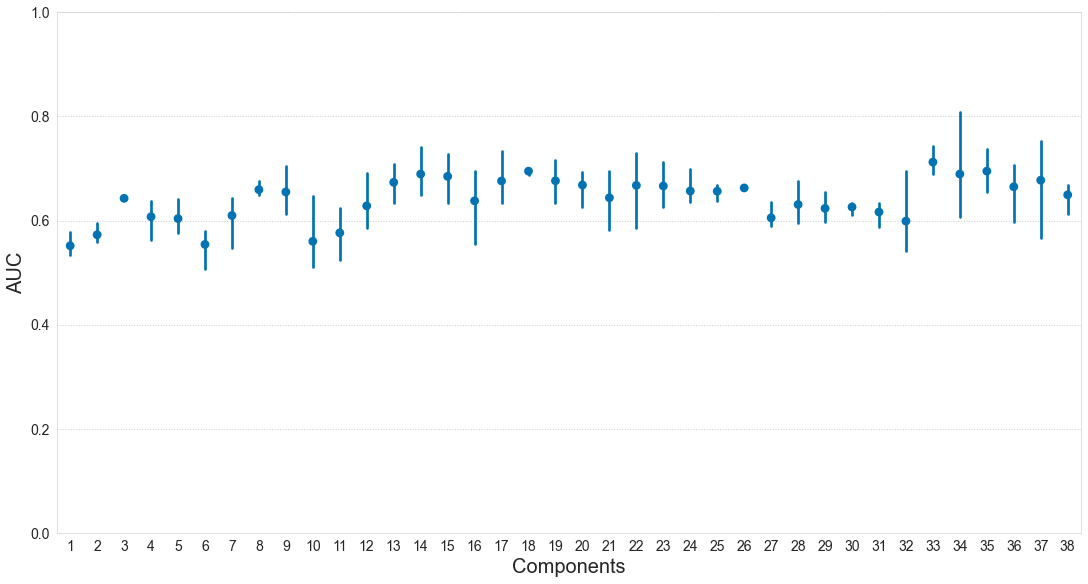

In [4]:
ax, f = getSetup((15, 8), (1, 1))
b = sns.pointplot(data=df_comp, x='Components', y='AUC', ax=ax[0], s=70, join=False) # blue
b.set_xlabel("Components",fontsize=20)
b.set_ylabel("AUC",fontsize=20)
b.tick_params(labelsize=14)
ax[0].set_ylim(0, 1)


# Figure 4

In [ ]:
_, statusID = get_patient_info()
outcomes = produce_outcome_bools(statusID)
components = 38
patient_matrices = pickle.load( open( "cyto_exp.p", "rb" ) )
values_comps = []
patient_matrix = patient_matrices[components - 1][1][2]
for i in range(0, components - 1):
    for j in range(i + 1, components):
        double = np.vstack((patient_matrix[:, i], patient_matrix[:, j])).T
        decisions = find_SVC_proba(double, outcomes)        
        auc = roc_auc_score(outcomes, decisions)
        values_comps.append([i, j, auc])
df_comp = pd.DataFrame(values_comps)
df_comp.columns = ["First", "Second", "AUC"]
df_comp = df_comp.sort_values(by=["AUC"], ascending=False)
display(df_comp)

In [10]:
patient_matrices = pickle.load( open( "cyto_exp.p", "rb" ) )
components = 38
_, cytos, _ = form_MRSA_tensor(1, 1)
patient_mats_applied = apply_parafac2_projections(patient_matrices[components - 1])
pickle.dump( patient_mats_applied, open( "Factors.p", "wb" ) )

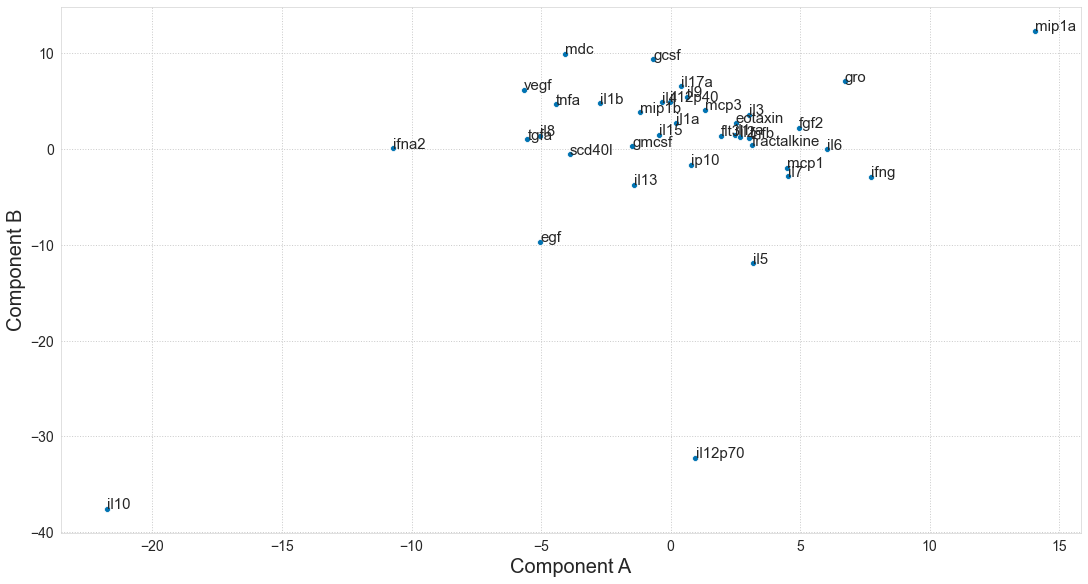

In [11]:
patient_mats_applied = pickle.load( open( "Factors.p", "rb" ) )
cytoA = patient_mats_applied[1][1][0].T[8]
cytoB = patient_mats_applied[1][1][0].T[32]
cyto_df = pd.DataFrame([cytoA, cytoB, cytos]).T
cyto_df.index = cytos
cyto_df.columns = ["Component A", "Component B", "Cytokines"]
ax, f = getSetup((15, 8), (1, 1))
b = sns.scatterplot(data=cyto_df, x='Component A', y='Component B', ax=ax[0]) # blue
b.set_xlabel("Component A",fontsize=20)
b.set_ylabel("Component B",fontsize=20)
b.tick_params(labelsize=14)
def label_point(cyto_df, ax):
    for i, point in cyto_df.iterrows():
        ax.text(point['Component A']+.002, point['Component B'], str(point['Cytokines']), fontsize=15)

label_point(cyto_df, ax[0])

# Figure 5

In [14]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return

In [12]:
pickle.dump( patient_matrices[components - 1], open( "Parafac2tensor.p", "wb" ) )

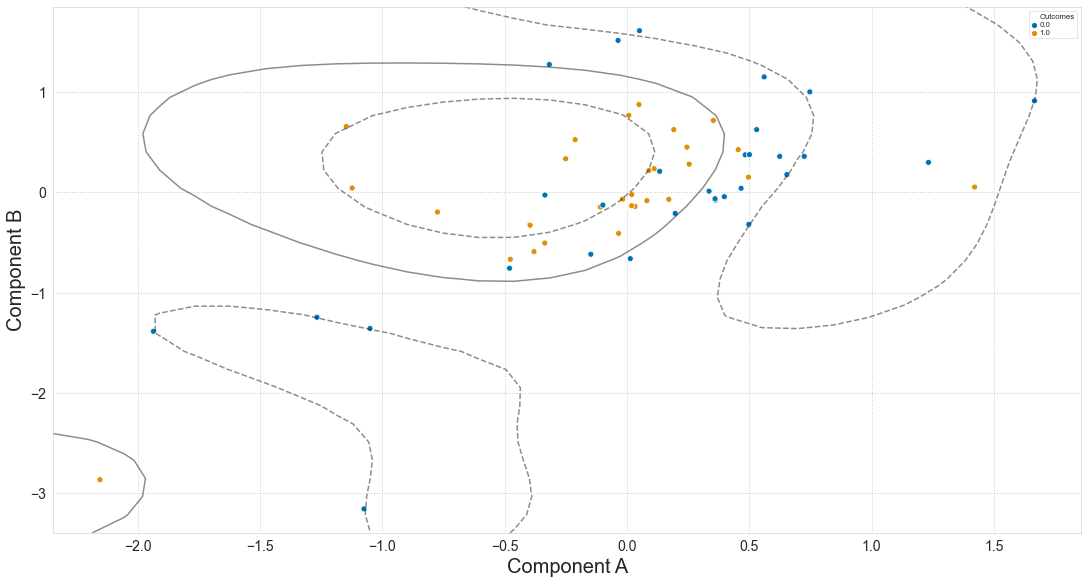

In [15]:
patient_matrices = pickle.load( open( "Parafac2tensor.p", "rb" ) )
cytoA = patient_matrices[1][2].T[8]
cytoB = patient_matrices[1][2].T[32]
cyto_df = pd.DataFrame([cytoA, cytoB, outcomes]).T
cyto_df.columns = ["Component A", "Component B", "Outcomes"]
ax, f = getSetup((15, 8), (1, 1))
b = sns.scatterplot(data=cyto_df, x='Component A', y='Component B', hue="Outcomes", ax=ax[0]) # blue
b.set_xlabel("Component A",fontsize=20)
b.set_ylabel("Component B",fontsize=20)
b.tick_params(labelsize=14)

double = np.vstack((cytoA, cytoB)).T
clf = SVC()
clf.fit(double, outcomes)
plot_svc_decision_function(clf, ax=ax[0])